# FPS-URB-RCC STAGE-0 WRF sensitivity experiment design

The simulation of this experiment are collected in [FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml](./FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml).

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import yaml
import warnings
warnings.simplefilter('ignore')

## Directed graph

In [14]:
# Generate color per insitution
def generate_color_map(institutions):
    """Generate a color map where each institution gets a unique color."""
    institution_colors = {}
    colors = plt.cm.get_cmap('tab20', len(institutions))  # Use a colormap with 20 distinct colors
    for idx, institution in enumerate(institutions):
        institution_colors[institution] = colors(idx)  # Assign a unique color per institution
    return institution_colors

# Plot diagram
def plot_graph(simul_data):
    color_map = []
    node_border_colors = []  # Colors of polygons
    node_border_widths = []  # Thickness of the node borders
    institution_map = {}
    
    G = nx.DiGraph()    
    
    # Collect unique institution_ids
    institutions = set([node['institution_id'] for node in simul_data['simulations']])
    
    # Generate a unique color per institution_id
    institution_colors = generate_color_map(institutions)
    
    for node in simul_data['simulations']:
        parent_id = node.get('parent_id')
        status = node.get('status')
        label = f"{node['simulation_id']}\n({node['institution_id']})"
        G.add_node(node['simulation_id'], label=label)  
        
        # Map node to institution
        institution_map[node['simulation_id']] = node['institution_id']  

        if parent_id is not None:
            G.add_edge(parent_id, node['simulation_id'])
                     
    # Positioning nodes
    pos = nx.shell_layout(G, nlist=[
        [node['simulation_id'] for node in simul_data['simulations'] if "CTRL" in node['simulation_id']],  # CTRL nodes
        [node['simulation_id'] for node in simul_data['simulations'] if "CTRL" not in node['simulation_id']]  # Other nodes
    ])

    # Define labels for the graph
    labels = {k: v['label'] for k, v in G.nodes.items()}
    
    # Plot
    plt.figure(figsize=(15, 15))    
    for node in G:
        institution = institution_map[node]
        status = next((n['status'] for n in simul_data['simulations'] if n['simulation_id'] == node), None)

        # Status-based edge colors
        if status in ["published"]:   
            color_map.append(institution_colors[institution])  
            node_border_colors.append('black')  
            node_border_widths.append(1)          
        elif status in ["completed"]:
            color_map.append('white')  
            node_border_colors.append('blue')                                        
            node_border_widths.append(3)                
        elif status in ["planned"]:
            color_map.append('white')
            node_border_colors.append('red')
            node_border_widths.append(3)
        else:
            print(f'Status of the simuation', node, 'not known, check!')  # Nodes not published or completed will be white
            exit()
     

    # Set different node sizes for 'CTRL' simulations
    node_sizes = [9000 if "CTRL" in node else 6000 for node in G.nodes()]
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=color_map, node_shape='8',
                           edgecolors=node_border_colors, linewidths=node_border_widths, cmap=plt.cm.tab20)

    # Draw the labels
    nx.draw_networkx_labels(G, pos, labels=labels)

    # change colors of the arrows and plot the arrows
    edge_colors = []
    edge_colors=['grey' if "CTRL" in node else 'black' for node in G.nodes()]
    edge_colors=edge_colors[1:len(G.nodes)]   
    nx.draw_networkx_edges(
        G, pos, arrows=True, arrowstyle='-|>', arrowsize=15, edge_color=edge_colors,
        node_size=node_sizes, connectionstyle='arc3'
    )

    # Save the plot
    plt.savefig("Sensitivity_array.png")
    plt.show()

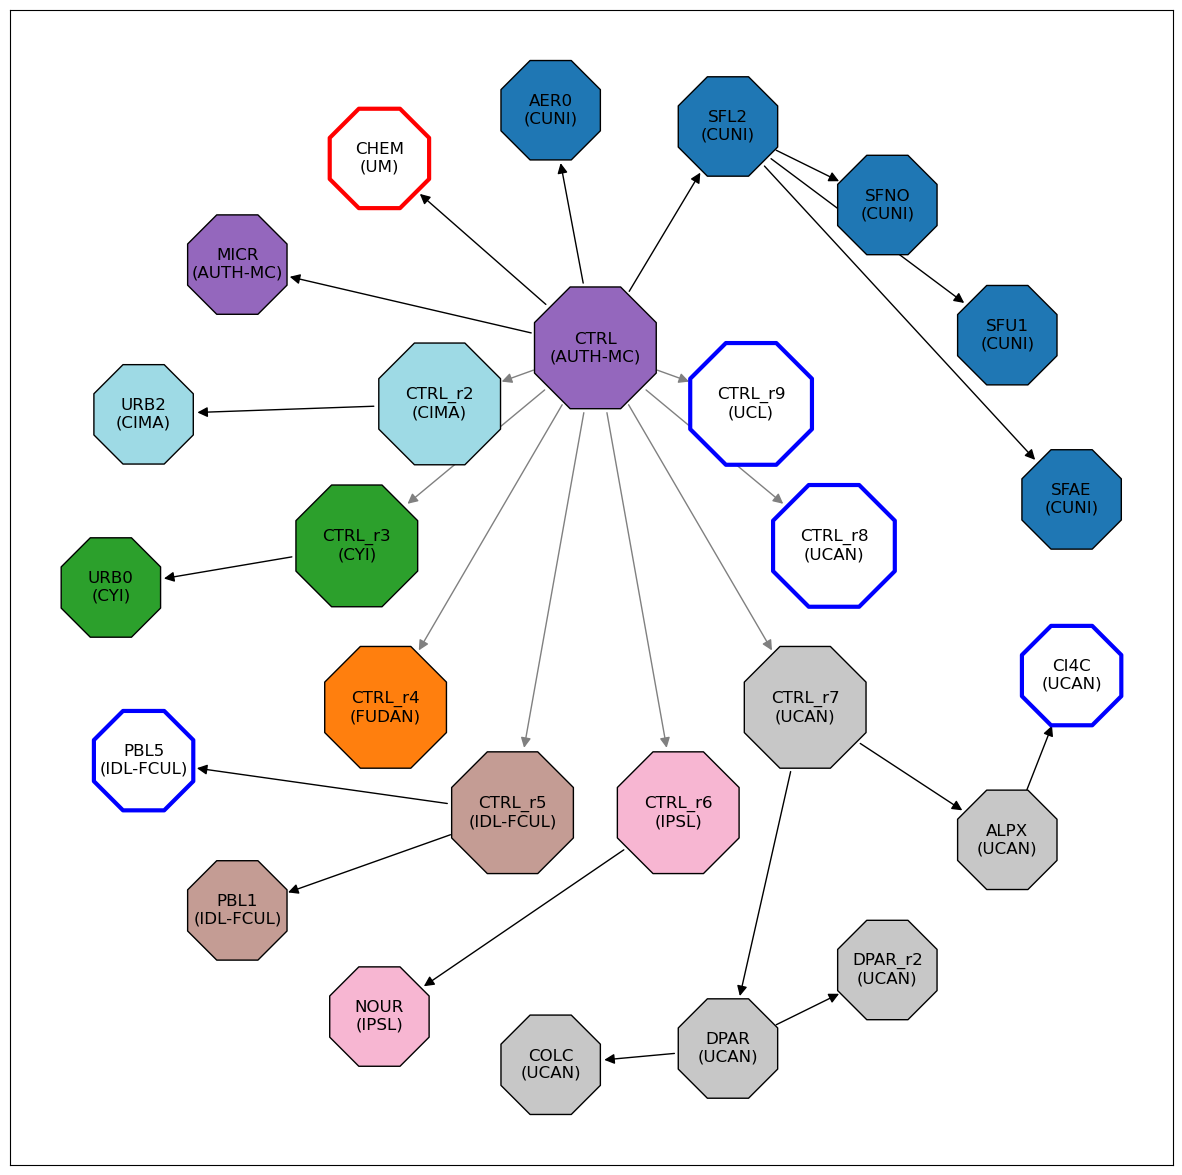

In [15]:
with open('FPS-URB-RCC_STAGE-0_WRF_experiment_design.yaml', 'r') as file:
    simul_data = yaml.safe_load(file)
plot_graph(simul_data)

## Simulation table

In [16]:
import pandas as pd
df = pd.DataFrame()
for sim in simul_data['simulations']:
    df = df.append(sim, ignore_index=True)
df.set_index("simulation_id", inplace=True)
df = df[["parent_id", "simulation", "institution_id", "parameters", "description"]]
df

,parent_id,simulation,institution_id,parameters,description
simulation_id,,,,,
CTRL,None,"Control simulation, realization 1",AUTH-MC,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r2,CTRL,"Control simulation, realization 2",CIMA,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r3,CTRL,"Control simulation, realization 3",CYI,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r4,CTRL,"Control simulation, realization 4",FUDAN,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r5,CTRL,"Control simulation, realization 5",IDL-FCUL,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r6,CTRL,"Control simulation, realization 6",IPSL,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r7,CTRL,"Control simulation, realization 7 perfored on ...",UCAN,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r8,CTRL,"Control simulation, realization 8 perfored on ...",UCAN,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
CTRL_r9,CTRL,"Control simulation, realization 9 perfored on ...",UCL,sf_sfclay_physics: 1 sf_urban_physics: 3 bl_pb...,EUR-12->PAR-3 nesting; WUDAPT LCZs on LANDMATE...
